# Coursework for Cardiac MR Image Segmentation (2021-2022)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [1]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

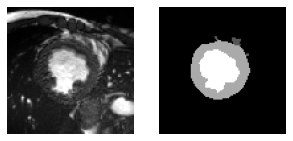

In [2]:
import os
import cv2 #import OpenCV

data_dir = './data/test'
for i in range(121,122):
    image = cv2.imread(os.path.join(data_dir,'image','cmr'+str(i)+'.png'), cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(os.path.join(data_dir,'mask','cmr'+str(i)+'_mask.png'), cv2.IMREAD_UNCHANGED)
    show_image_mask(image, mask, cmap='gray')
    plt.pause(1)
#cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [3]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# random seed
torch.cuda.manual_seed(1) 

dropout = 0.2
class Encoder(nn.Module):
    """the first 13 layers of VGG16, remaining indices during maxpooling"""
    def __init__(self, input_channels):
        super(Encoder, self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=bn_momentum),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, momentum=bn_momentum),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.encoder5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        id = []

        x = self.encoder1(x)
        x, id1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id1)
        x = self.encoder2(x)
        x, id2 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id2)
        x = self.encoder3(x)
        x, id3 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id3)
        x = self.encoder4(x)
        x, id4 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id4)
        x = self.encoder5(x)
        x, id5 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id5)

        return x, id

    
bn_momentum = 0.1


class SegNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SegNet, self).__init__()

        # self.weights_new = self.state_dict()  # for loading pre-trained weights
        self.encoder = Encoder(input_channels)

        self.decoder1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, momentum=bn_momentum),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=bn_momentum),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=bn_momentum),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv2d(64, output_channels, kernel_size=3, stride=1, padding=1),
        )

        
    def forward(self, x):
        x, id = self.encoder(x)

        x = F.max_unpool2d(x, id[4], kernel_size=2, stride=2)
        x = self.decoder1(x)
        x = F.max_unpool2d(x, id[3], kernel_size=2, stride=2)
        x = self.decoder2(x)
        x = F.max_unpool2d(x, id[2], kernel_size=2, stride=2)
        x = self.decoder3(x)
        x = F.max_unpool2d(x, id[1], kernel_size=2, stride=2)
        x = self.decoder4(x)
        x = F.max_unpool2d(x, id[0], kernel_size=2, stride=2)
        x = self.decoder5(x)

        return x    

In [5]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    np.sum(mask1_pos) + np.sum(mask2_pos)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

In [6]:
class losses():
    def __init__(self):
        #self.dice = categorical_dice()  
        #self.dice = categorical_dice()
        self.CE= nn.CrossEntropyLoss()
        
    def forward(self, pred, true):
        #self.val = 0
#       for i in range(3)
#        for i in range (3):
#            self.val += self.dice(mask.data.cpu().numpy, real_mask.data.cpu().numpy, i+1)
#        self.val = self.val / 3
        return self.CE(pred,true)

    def forward2(self,pred,true,pred_mask,true_mask):
#         pred_mask.data.cpu().numpy(
#         true_mask.data.cpu().numpy(
        logp = self.CE(pred, true)
        p = torch.exp(-logp)
        self.gamma = 2
        loss = (1 - p) ** self.gamma * logp
        self.val = 0
        for i in range(3):
            self.val = self.val + categorical_dice(pred_mask.data.cpu().numpy(), true_mask.data.cpu().numpy(), i+1)
        
        return loss.mean() + self.CE(pred,true) + (3 - self.val)/2

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

model = SegNet(1, 4) # We can now create a model using your defined segmentation model
model = model.to(device)

The current device is cuda:0


### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [8]:
import torch.optim as optim

# lossfn = nn.CrossEntropyLoss()
my_loss = losses()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
learning_rate = 0.001
weight_decay=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

Start Training:
[epoch 1]  training loss: 0.540  validation loss: 2.008  training dice score: 0.002  validation dice score: 0.004
1  saved model
[epoch 2]  training loss: 0.419  validation loss: 1.325  training dice score: 0.367  validation dice score: 0.346
2  saved model
[epoch 3]  training loss: 0.269  validation loss: 1.237  training dice score: 0.476  validation dice score: 0.449
3  saved model
[epoch 4]  training loss: 0.216  validation loss: 1.086  training dice score: 0.581  validation dice score: 0.489
4  saved model
[epoch 5]  training loss: 0.162  validation loss: 0.955  training dice score: 0.616  validation dice score: 0.539
5  saved model
[epoch 6]  training loss: 0.166  validation loss: 0.804  training dice score: 0.647  validation dice score: 0.626
6  saved model
[epoch 7]  training loss: 0.155  validation loss: 0.644  training dice score: 0.715  validation dice score: 0.699
7  saved model
[epoch 8]  training loss: 0.139  validation loss: 0.923  training dice score: 0.6

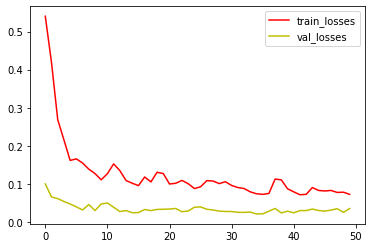

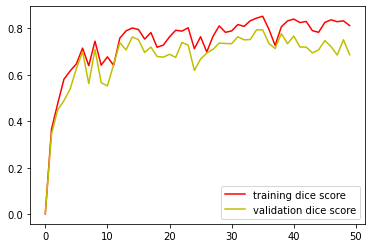

In [9]:
from torch.utils.data import DataLoader
import time
import numpy as np


np.seterr(invalid='ignore')

train_data_path = './data/train'
val_data_path = './data/val'
num_workers = 0
batch_size = 4
num_epochs = 50
train_set = TrainDataset(train_data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
val_set = TrainDataset(val_data_path)
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=1, shuffle=False)
training_loader_4metric = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=1, shuffle=False)
Max_val = 0

train_losses = []
val_losses = []

train_dice_plt = []
val_dice_plt = []

# max_score = 0

print("Start Training:")
t0 = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    model.train()
    training_loss = 0.0
    training_loss_iter = 0.0
    for iteration, sample in enumerate(training_data_loader):
        # get the inputs; data is a list of [inputs, labels] and move them to
        #the current device
        img, mask = sample
        #show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
        #plt.pause(1)
        
        img = img.view(batch_size, 1, 96, 96)
        img = img.to(device)
        mask = mask.to(device)
        #print(img.shape)
        #print(mask.shape)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(img)
        output = outputs.argmax(dim=1)
        loss = my_loss.forward2(outputs,mask.long(),mask, output)
        # loss = lossfn(outputs, mask.long())
        loss.backward()
        optimizer.step()

        # print statistics - epoch and loss
        training_loss_iter += loss.item()
        if iteration % 5 == 4:    # print every 5 mini-batches
            #print('[%d, %5d] loss: %.3f' % (epoch + 1, iteration + 1, training_loss_iter / (5 * batch_size)))
            training_loss += training_loss_iter
            training_loss_iter = 0.0
            
    train_losses.append(training_loss/100)
    
    # compute the validation loss and dice score metric on full validation set and training set per epoch
    with torch.no_grad():       # fix the model's params (reduces cost)
        model.eval()       # set model to evaluation mode
        validation_loss = 0.0
        val_metric = 0.0
        train_metric = 0.0
        
        # compute the validation loss and validation metric
        for iteration, val_sample in enumerate(val_data_loader):
            val_img, val_mask = val_sample
            val_img = val_img.view(1, 1, 96, 96)  # set batch_size to be 1 here
            
            # the model is on GPU, so move data to device
            val_img = val_img.to(device)
            val_mask = val_mask.to(device)
            
            # forward
            val_outputs = model(val_img)
            
            # compute loss
            val_output = val_outputs.argmax(dim=1)
            loss_val = my_loss.forward2(val_outputs,val_mask.long(),val_mask, val_output)
            # loss_val = lossfn(val_outputs, val_mask.long())
            validation_loss += loss_val.item()
            
            # compute dice score metric
            _, mask_predict = torch.max(val_outputs, 1) # Returns a tuple (max,max indicies), we only need the max indicies.
            mask_predict = mask_predict.view(96, 96).cpu().numpy()
            val_mask = val_mask.view(96, 96).cpu().numpy()
            dice_score = 0   # per instance
            dices = []
            # ignore the dice score for background (label 0)
            for i in range(1, 4):
                dices.append(categorical_dice(val_mask, mask_predict, label_class=i))
            # compute mean dice score without nan produced when both masks don't contain label_class i
            dice_score = np.nanmean(np.array(dices))
            val_metric += dice_score
        
        # compute the training metric
        for iteration, train_sample in enumerate(training_loader_4metric):
            train_img, train_mask = train_sample
            train_img = train_img.view(1, 1, 96, 96)  # set batch_size to be 1 here
            
            # the model is on GPU, so move data to device
            train_img = train_img.to(device)
            train_mask = train_mask.to(device)
            
            # forward
            train_outputs = model(train_img)
            
            # compute dice score metric
            _, mask_predict_train = torch.max(train_outputs, 1) # Returns a tuple (max,max indicies), we only need the max indicies.
            mask_predict_train = mask_predict_train.view(96, 96).cpu().numpy()
            train_mask = train_mask.view(96, 96).cpu().numpy()
            dice_score = 0   # per instance
            dices = []
            # ignore the dice score for background (label 0)
            for i in range(1, 4):
                dices.append(categorical_dice(train_mask, mask_predict_train, label_class=i))
            # compute mean dice score without nan produced when both masks don't contain label_class i
            dice_score = np.nanmean(np.array(dices))
            train_metric += dice_score
        
        # compute the validation loss on full validation set
        validation_loss /= 20.0
        val_metric /= 20.0
        train_metric /= 100.0
    
    val_losses.append(validation_loss/20)
    
    train_dice_plt.append(train_metric)
    val_dice_plt.append(val_metric)
       
    # print the training and validation loss/metric per epoch
    print('[epoch %d]  training loss: %.3f  validation loss: %.3f  training dice score: %.3f  validation dice score: %.3f' %
                  (epoch + 1, training_loss / 100, validation_loss, train_metric, val_metric))
    
    if Max_val < val_metric:
        Max_val = val_metric
        print(epoch+1, " saved model")
        PATH = './segnet_vgg16.pth'
        torch.save(model.state_dict(), PATH)

t1 = time.time()
print('Finished Training in %.3f seconds' % (t1- t0))

print(len(train_losses))
print(len(val_losses))
plt.plot(range(num_epochs), train_losses,c='r',label = "train_losses")
plt.plot(range(num_epochs), val_losses,c='y',label = "val_losses") # 
plt.legend(loc='best')
plt.savefig('Segnet_vgg16_1.jpg')
plt.show()

plt.plot(range(num_epochs), train_dice_plt,c='r',label = "training dice score")
plt.plot(range(num_epochs), val_dice_plt,c='y',label = "validation dice score")
plt.legend(loc='best')
plt.savefig('Segnet_vgg16_2.jpg')
plt.show()

In [10]:
# PATH = './segnet_basic.pth'
# torch.save(model.state_dict(), PATH)

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [11]:
import numpy as np
from torch.autograd import Variable

In [12]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Automatically created module for IPython interactive environment


#### Validation

validation loss: 0.000
Confusion matrix, without normalization
[[0.97 0.18 0.08 0.  ]
 [0.02 0.77 0.01 0.  ]
 [0.01 0.05 0.88 0.12]
 [0.   0.   0.03 0.88]]


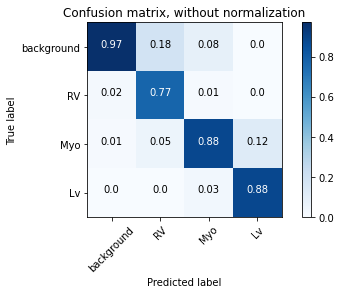

In [19]:
# validation on validation set, compute the loss
from torch.utils.data import DataLoader
import numpy as np
y_mmpre = []
y_mmlabel = []

PATH = './segnet_vgg16.pth'
val_data_path = './data/val'
num_workers = 0
batch_size = 1

val_set = TrainDataset(val_data_path)
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=1, shuffle=False)
model = SegNet(1, 4)
model.load_state_dict(torch.load(PATH))

with torch.no_grad():       # fix the model's params (reduces cost)
    model.eval()       # set model to evaluation mode
    validation_loss = 0.0
    for iteration, sample in enumerate(val_data_loader):
        img, mask = sample
        #show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
        #plt.pause(1)
        img = img.view(batch_size, 1, 96, 96)

        # forward
        outputs = model(img)
    
        #img, mask = sample
        #img = img.to(device)
        #mask = mask.to(device)
        #img = img.unsqueeze(1)
        #with torch.no_grad():
        #    outputs = model(img)
        #    output = outputs.argmax(dim=1)
        # compute loss
        # loss = my_loss(outputs, mask.long())
        # validation_loss += loss.item()
        #print(loss.item())
        outputs2 = outputs.argmax(dim = 1)

        for i in range(96):
            for j in range(96):
                y_mmpre.append(int(outputs2[0][i][j].item()))
                y_mmlabel.append(int(mask[0][i][j].item()))
                
    # compute the validation loss on full validation set
    validation_loss /= 20.0
    
    # print the training and validation loss per epoch
    print('validation loss: %.3f' % (validation_loss))
    
cm = np.zeros((4, 4)) # matrics
cnt = [0, 0, 0, 0]

#for i in range(4):
#    print(y_mmlabel[i])
for i in range(len(y_mmlabel)):
    cnt[y_mmlabel[i]] = cnt[y_mmlabel[i]] + 1
    
for i in range(len(y_mmpre)):
    cm[y_mmpre[i]][y_mmlabel[i]] = cm[y_mmpre[i]][y_mmlabel[i]] + 1

for i in range(4):
    for j in range(4):
        cm[i][j] = cm[i][j] / cnt[j]
        cm[i][j] = round(cm[i][j], 2)
        
class_names = ['background', 'RV', 'Myo', 'Lv']

# y_mlabel = np.array(y_mmlabel)
# y_mpre = np.array(y_mmpre)

# cnf_matrix = confusion_matrix(y_mlabel, y_mpre)
# for i in range(4):
#    for j in range(4):
#        cnf_matrix[i][j] = round(cnf_matrix[i][j], 2)

# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=False,
                      title='Confusion matrix, without normalization')
plt.savefig('Segnet_vgg16_3.jpg')
plt.show()
    
#print("validation total loss: %f" % (val_total_loss))
#val_eva_loss = val_total_loss / (val_batch_size * len(val_data_loader))
#print("validation total loss: %f" % (val_eva_loss))

image 1 on validation set: 
original image:


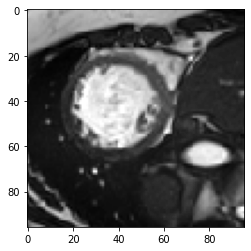

ground truth mask:


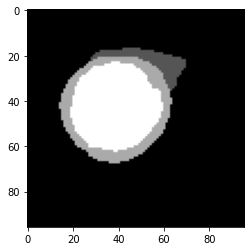

predicted mask:


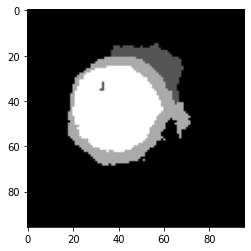

image 2 on validation set: 
original image:


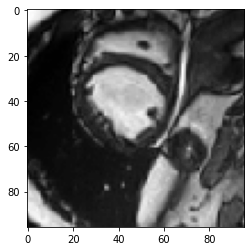

ground truth mask:


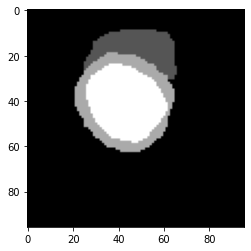

predicted mask:


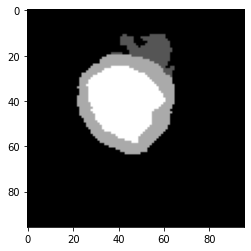

image 3 on validation set: 
original image:


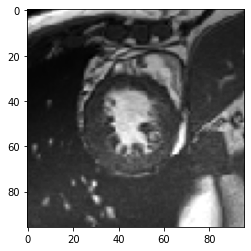

ground truth mask:


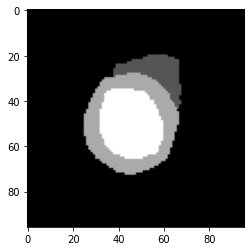

predicted mask:


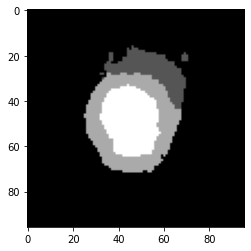

image 4 on validation set: 
original image:


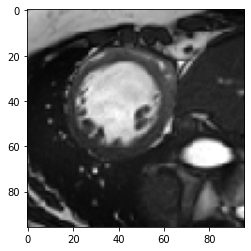

ground truth mask:


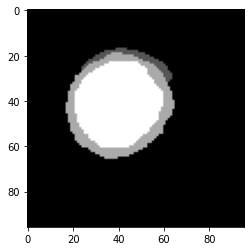

predicted mask:


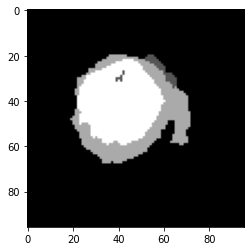

image 5 on validation set: 
original image:


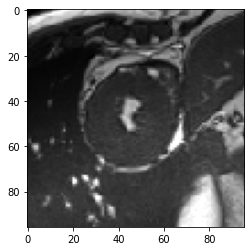

ground truth mask:


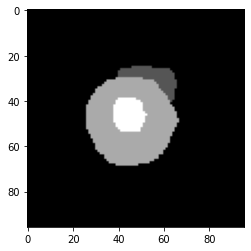

predicted mask:


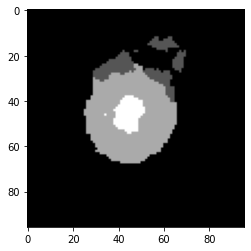

image 6 on validation set: 
original image:


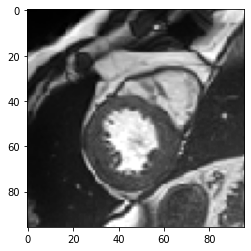

ground truth mask:


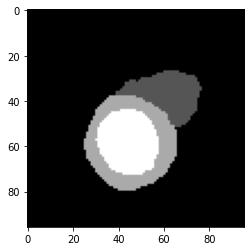

predicted mask:


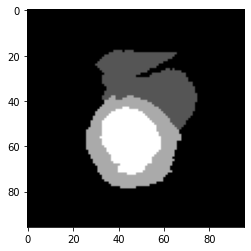

image 7 on validation set: 
original image:


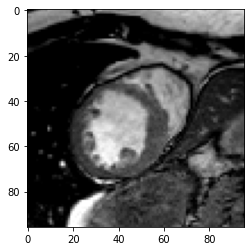

ground truth mask:


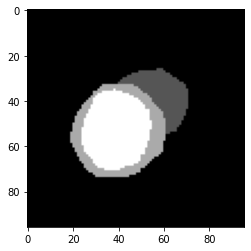

predicted mask:


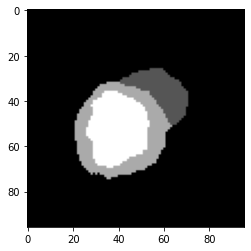

image 8 on validation set: 
original image:


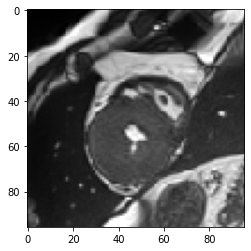

ground truth mask:


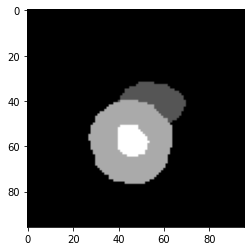

predicted mask:


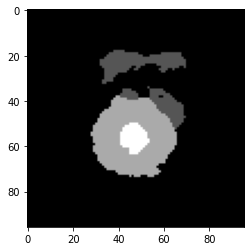

image 9 on validation set: 
original image:


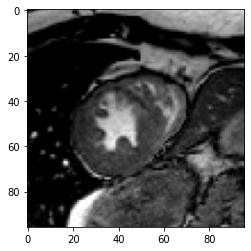

ground truth mask:


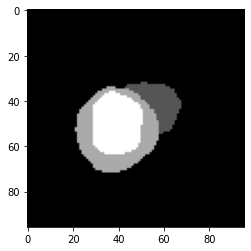

predicted mask:


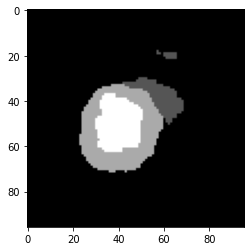

image 10 on validation set: 
original image:


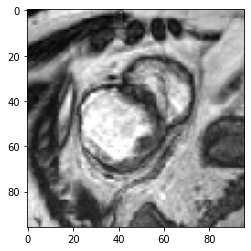

ground truth mask:


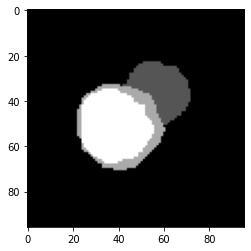

predicted mask:


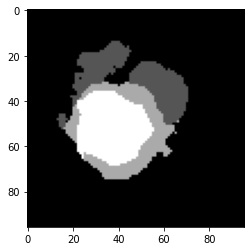

image 11 on validation set: 
original image:


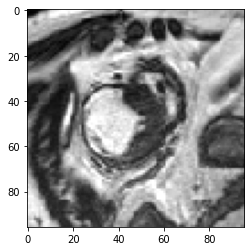

ground truth mask:


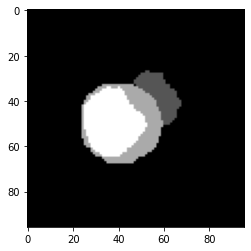

predicted mask:


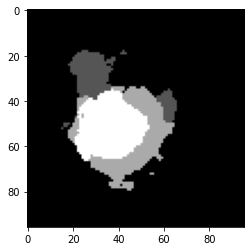

image 12 on validation set: 
original image:


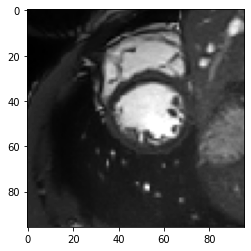

ground truth mask:


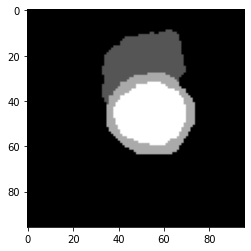

predicted mask:


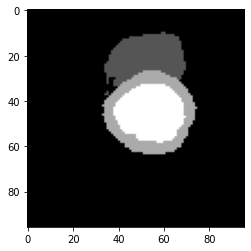

image 13 on validation set: 
original image:


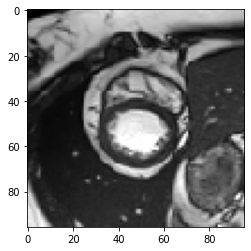

ground truth mask:


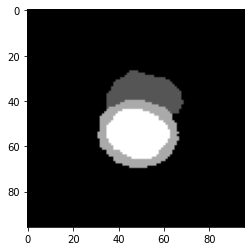

predicted mask:


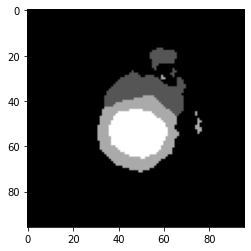

image 14 on validation set: 
original image:


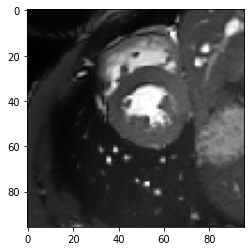

ground truth mask:


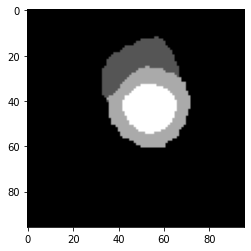

predicted mask:


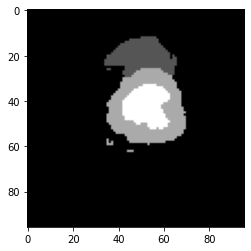

image 15 on validation set: 
original image:


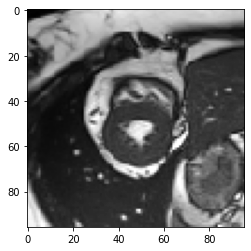

ground truth mask:


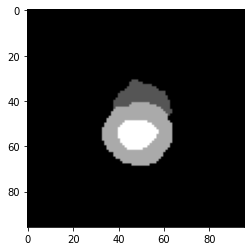

predicted mask:


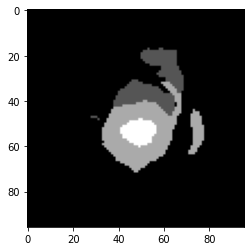

image 16 on validation set: 
original image:


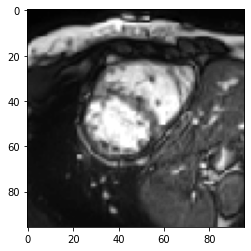

ground truth mask:


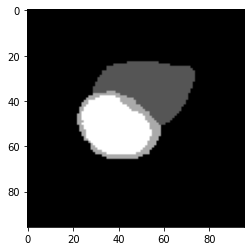

predicted mask:


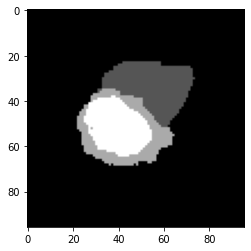

image 17 on validation set: 
original image:


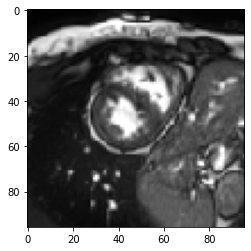

ground truth mask:


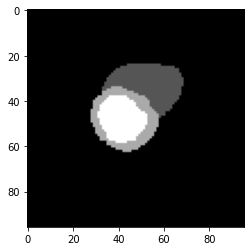

predicted mask:


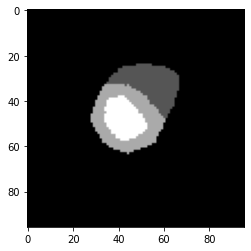

image 18 on validation set: 
original image:


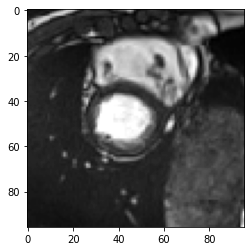

ground truth mask:


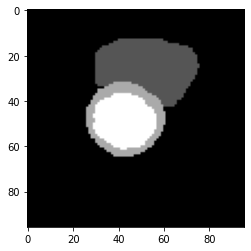

predicted mask:


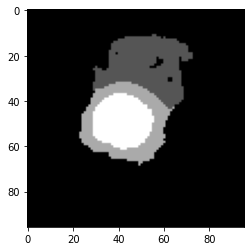

image 19 on validation set: 
original image:


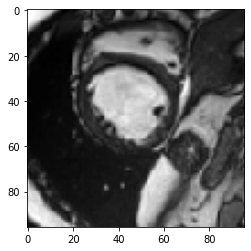

ground truth mask:


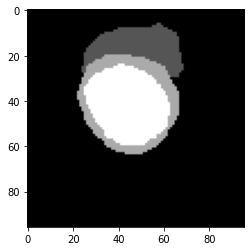

predicted mask:


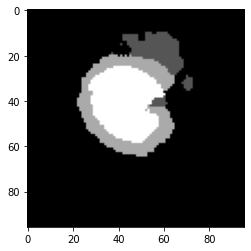

image 20 on validation set: 
original image:


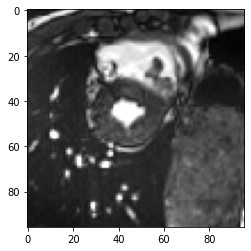

ground truth mask:


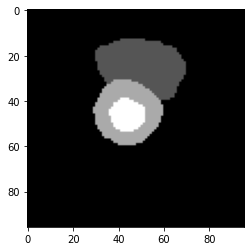

predicted mask:


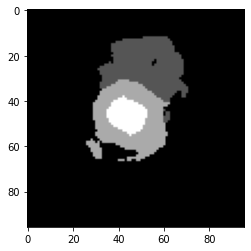

In [20]:
# visualize the predicted mask and the ground truth mask on validtion set
PATH = './segnet_vgg16.pth'
data_path = './data/val'
num_workers = 0
batch_size = 1

val_set = TrainDataset(data_path)
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

model = SegNet(1, 4)
model.load_state_dict(torch.load(PATH))

for iteration, sample in enumerate(val_data_loader):
    print('image %d on validation set: '% (iteration + 1))
    img, mask = sample
    
    print("original image:")
    img = img.view(batch_size, 1, 96, 96)
    plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    plt.pause(1)
    
    print("ground truth mask:")
    plt.imshow( mask[0,...].squeeze(), cmap='gray') #visualise all data in training set
    plt.pause(1)
    
    
    with torch.no_grad():       # fix the model's params (reduces cost)
        model.eval()       # set model to evaluation mode
        outputs = model(img)
        _, mask = torch.max(outputs, 1) #Returns a tuple (max,max indicies), we only need the max indicies.
        
    print("predicted mask:")
    plt.imshow(mask[0,...].squeeze(), cmap='gray') #visualise all images in test set
    plt.pause(1)
    

#### Testing on test set

In [ ]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
import time


PATH = './segnet_vgg16.pth'
data_path = './data/test'
num_workers = 0
batch_size = 1

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

model = SegNet(1, 4)
model.load_state_dict(torch.load(PATH))

t0 = time.time()
for iteration, sample in enumerate(test_data_loader):
    img = sample.view(batch_size, 1, 96, 96)
    #print(img.shape)

    # plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    # plt.pause(1)
    
    with torch.no_grad():       # fix the model's params (reduces cost)
        model.eval()       # set model to evaluation mode
        outputs = model(img)
        _, mask = torch.max(outputs, 1) #Returns a tuple (max,max indicies), we only need the max indicies.
    # print(mask.shape)    
    # plt.imshow(mask[0,...].squeeze(), cmap='gray') #visualise all images in test set
    # plt.pause(1)
    
    pictureName = "cmr" + str(121+iteration) + "_mask.png"
    print(pictureName)
    #cv2.imwrite(os.path.join('./data/test/mask',pictureName), mask.cpu().numpy().squeeze(0).astype('uint8'))

t1 = time.time()
print('Inference time: %.2f ms' % ((t1-t0)*1000/80))

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

In [ ]:
# validation on validation set, compute the dice score
from torch.utils.data import DataLoader
import numpy as np

PATH = './segnet_vgg16.pth'
val_data_path = './data/val'
num_workers = 0

val_set = TrainDataset(val_data_path)
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=1, shuffle=False)
model = SegNet(1, 4)
model.load_state_dict(torch.load(PATH))

with torch.no_grad():       # fix the model's params (reduces cost)
    model.eval()       # set model to evaluation mode
    metric = 0.0
    for iteration, sample in enumerate(val_data_loader):
        img, mask = sample
        img = img.view(1, 1, 96, 96)

        # forward
        outputs = model(img)
    
        # compute metric
        _, mask_predict = torch.max(outputs, 1) #Returns a tuple (max,max indicies), we only need the max indicies.
        mask_predict = mask_predict.view(96, 96).numpy()
        mask = mask.view(96, 96).numpy()
        dice_score = 0
        dices = []
        for i in range(1, 4):
            dices.append(categorical_dice(mask, mask_predict, label_class=i))
        # compute mean dice score without nan produced when both masks don't contain label_class i
        dice_score = np.nanmean(np.array(dices))
        metric += dice_score
        print('[%d] dice score: %.3f' % ((iteration, dice_score)))
    
    metric /= 20
    
    # print the training and validation loss per epoch
    print('validation dice score: %.3f' % (metric))

In [ ]:
# validation on training set, compute the dice score
from torch.utils.data import DataLoader
import numpy as np

np.seterr(invalid='ignore')
PATH = './segnet_vgg16.pth'
train_data_path = './data/train'
num_workers = 0
batch_size = 1

train_set = TrainDataset(train_data_path)
training_loader_4metric = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=False)
model = SegNet(1, 4)
model.load_state_dict(torch.load(PATH))

with torch.no_grad():       # fix the model's params (reduces cost)
    model.eval()       # set model to evaluation mode
    metric = 0.0
    for iteration, sample in enumerate(training_loader_4metric):
        img, mask = sample
        img = img.view(batch_size, 1, 96, 96)

        # forward
        outputs = model(img)
    
        # compute metric
        _, mask_predict = torch.max(outputs, 1) #Returns a tuple (max,max indicies), we only need the max indicies.
        mask_predict = mask_predict.view(batch_size, 96, 96).numpy()
        mask = mask.view(batch_size, 96, 96).numpy()
        dice_score = 0
        dices = []
        for i in range(1, 4):
            dices.append(categorical_dice(mask, mask_predict, label_class=i))
        # compute mean dice score without nan produced when both masks don't contain label_class i
        dice_score = np.nanmean(np.array(dices)) 
        metric += dice_score
        print('[%d] dice score: %.3f' % ((iteration, dice_score)))
    
    metric /= 100
    
    # print the training and validation loss per epoch
    print('validation dice score: %.3f' % (metric))

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        if file == '.ipynb_checkpoints':
            continue
        
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)
  
        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

In [ ]:
mask_directory = './data/test/mask'
save = './'
submission_converter(mask_directory,save)